# Rekomendasi Buku menggunakan Langchain

Dibawah ini adalah libraries yang diperlukan

In [380]:
# pip install kagglehub
# pip install pandas
# pip install matplotlib
# pip install seaborn
# pip install numpy
# pip install langchain-community
# pip install langchain-openai : to work with openai
# pip install langchain-chroma : vector databases

## Import libraries

In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import langchain_community
import langchain_openai
import langchain_chroma

## Load data

In [382]:
import kagglehub

# Versi terbaru
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Lenovo\.cache\kagglehub\datasets\dylanjcastillo\7k-books-with-metadata\versions\3


````bash

PS C:\Users>
cd C:\Users\Lenovo\cache\kagglehub\datasets
\dylanjcastillo\7k-books-with-metadata\versions\3

PS C:\Users\Lenovo\cache\kagglehub\datasets
\dylanjcastillo\7k-books-with-metadata\versions\3> ls


    Directory: C:\Users\Lenovo\.cache\kagglehub\datasets\dylan 
    jcastillo\7k-books-with-metadata\versions\3


Mode                 LastWriteTime         Length Name
----                 -------------         ------ ----
-a----         1/29/2025  12:16 AM        4142211 books.csv    
````

In [383]:
book = pd.read_csv(f'{path}/books.csv')
book.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


In [384]:
book.shape

(6810, 12)

## Pola _missing data_

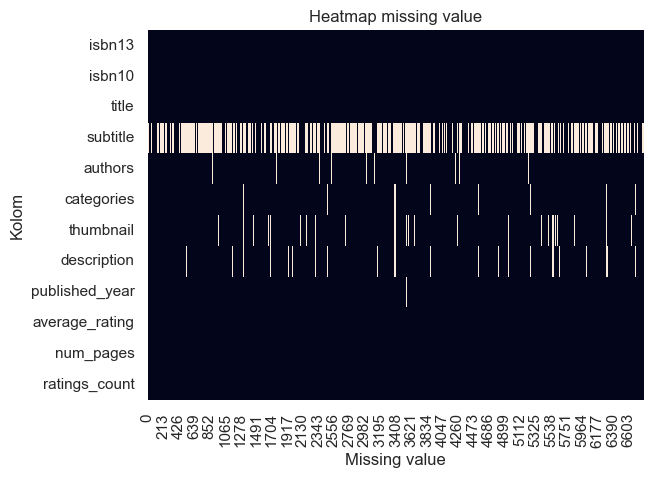

In [385]:
ax = plt.axes()
sns.heatmap(book.isna().transpose(), cbar=False, ax=ax)

plt.xlabel("Missing value")
plt.ylabel("Kolom")
plt.title("Heatmap missing value")

plt.show()

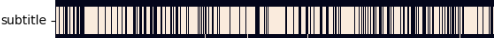 <br>
Seperti yang dilihat, **subtitle** memiliki _missing value_ yang banyak namun ini akan diurus nanti 

-------------------------------------------------------------

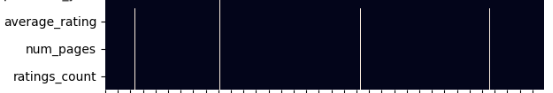 <br>
Terdapat pola yang jelas yang dapat dilihat pada 3 fitur ini, hal ini bisa jadi indikasi **sumber pengambilan data yang berbeda**.

-------------------------------------------------------------

Dapat diperhatikan juga bahwa ***Description*** memiliki _missing value_ , hal ini harus ditangani dikarenakan fitur inilah yang akan menjadi fitur utama dalam sistem ini.

Pentingnya mengetahui bahwa adanya bias di jenis deskripsi yang memiliki _missing value_, karena akan menghilangkan buku-buku ini dan mengetahui jika sistem rekomendasi akan condong ke buku yang mana. <br>
(<br>
**Dalam kata lain**:
-   Jika ada buku yang deskripsinya kosong, buku-buku itu tidak akan masuk ke dalam sistem rekomendasi. Artinya, hanya buku-buku yang memiliki deskripsi lengkap yang akan direkomendasikan.
-   Hal ini bisa membuat sistem rekomendasi menjadi tidak adil karena hanya memilih buku-buku tertentu (yang deskripsinya lengkap) dan mengabaikan buku-buku lain.<br>
)

In [386]:
book['missing_description'] = np.where(book['description'].isna(), 1, 0)
book['age_of_book'] = 2025 - book["published_year"]

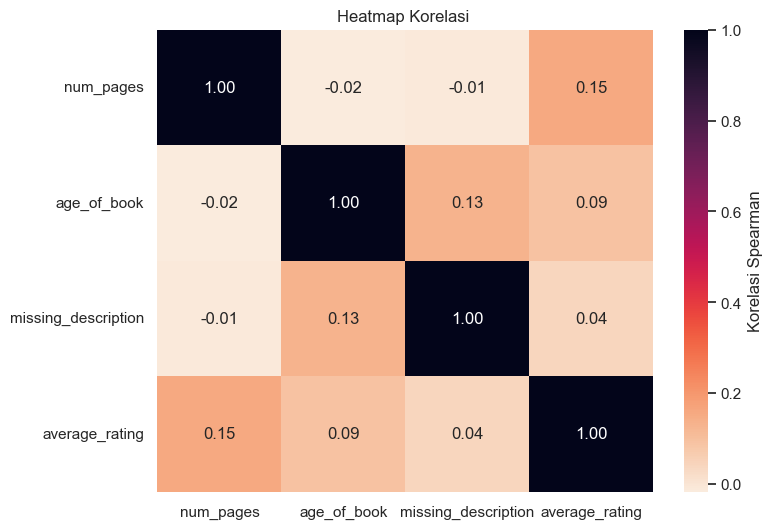

In [387]:
kolom_yang_dipakai = ["num_pages", "age_of_book", "missing_description", "average_rating"]

corr_matrix = book[kolom_yang_dipakai].corr(method="spearman")
# Kenapa pakai metode spearman?
# karna "missing_description" adalah binary dan spearman correlation coefficient
#   lebih baik digunakan untuk nilai non-kontinu

sns.set_theme(style="white")
plt.figure(figsize=(8,6))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", 
                      cmap = "rocket_r", cbar_kws={"label": "Korelasi Spearman"})

heatmap.set_title("Heatmap Korelasi ")
plt.show()

Yang akan disoroti adalah korelasi dari _missing_description_, dengan variabel yang lain dapat dicari tau bahwa variabel tersebut memiliki korelasi tinggi dengan deksripsi yang hilang. Hal ini akan memperlihatkan jika buku yang tidak memiliki deskripsi akan bias dan condong ke arah mana. Seperti contoh:

-   Jika korelasi _missing_description_ dengan _age_of_book_ tinggi, maka terdapat indikasi bahwa deskripsi yang hilang akan condong kearah buku yang sudah tua atau buku yang baru

**Tapi** semua nilai korelasi yang berkaitan dengan _missing_description_ tidak mengindikasikan korelasi yang kuat

Dengan ini nilai-nilai yang hilang dapat dihapus karena: 
-   Tidak adanya pola yang diperlihatkan dalam korelasi matrix
-   Tidak akan mengimputasi nilai yang hilang ini dikarenakan harus dilakukannya _web scraping_

In [388]:
# Hapus missing value pada 4 fitur
book_mv = book[
    ~(book['description'].isna()) & 
    ~(book['num_pages'].isna()) &
    ~(book['average_rating'].isna()) &
    ~(book['published_year'].isna()) 
                      ]
book_mv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6507 entries, 0 to 6809
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   isbn13               6507 non-null   int64  
 1   isbn10               6507 non-null   object 
 2   title                6507 non-null   object 
 3   subtitle             2281 non-null   object 
 4   authors              6444 non-null   object 
 5   categories           6474 non-null   object 
 6   thumbnail            6293 non-null   object 
 7   description          6507 non-null   object 
 8   published_year       6507 non-null   float64
 9   average_rating       6507 non-null   float64
 10  num_pages            6507 non-null   float64
 11  ratings_count        6507 non-null   float64
 12  missing_description  6507 non-null   int32  
 13  age_of_book          6507 non-null   float64
dtypes: float64(5), int32(1), int64(1), object(7)
memory usage: 737.1+ KB


## Cek kategori dan deskripsi

Disini akan dilihat fitur deskripsi dan kategori lebih detail lagi, karena kategori bisa jadi memberikan informasi tentang buku tersebut yang bisa kita rekomendasikan dan deskripsi adalah salah satu fitur utama dalam sistem rekomendasi ini

In [389]:
book_mv['categories'].value_counts().reset_index().sort_values("count", ascending=False)

,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
280,Butlers,1
279,Gardens,1
278,Assassins,1
277,Married people,1


In [390]:
book_mv['total_words_in_desc'] = book_mv['description'].str.split().str.len()
book_mv['total_words_in_desc'].describe()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_53572\2911097606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_mv['total_words_in_desc'] = book_mv['description'].str.split().str.len()


count    6507.000000
mean       66.325803
std        66.120291
min         1.000000
25%        27.000000
50%        40.000000
75%        82.000000
max       920.000000
Name: total_words_in_desc, dtype: float64

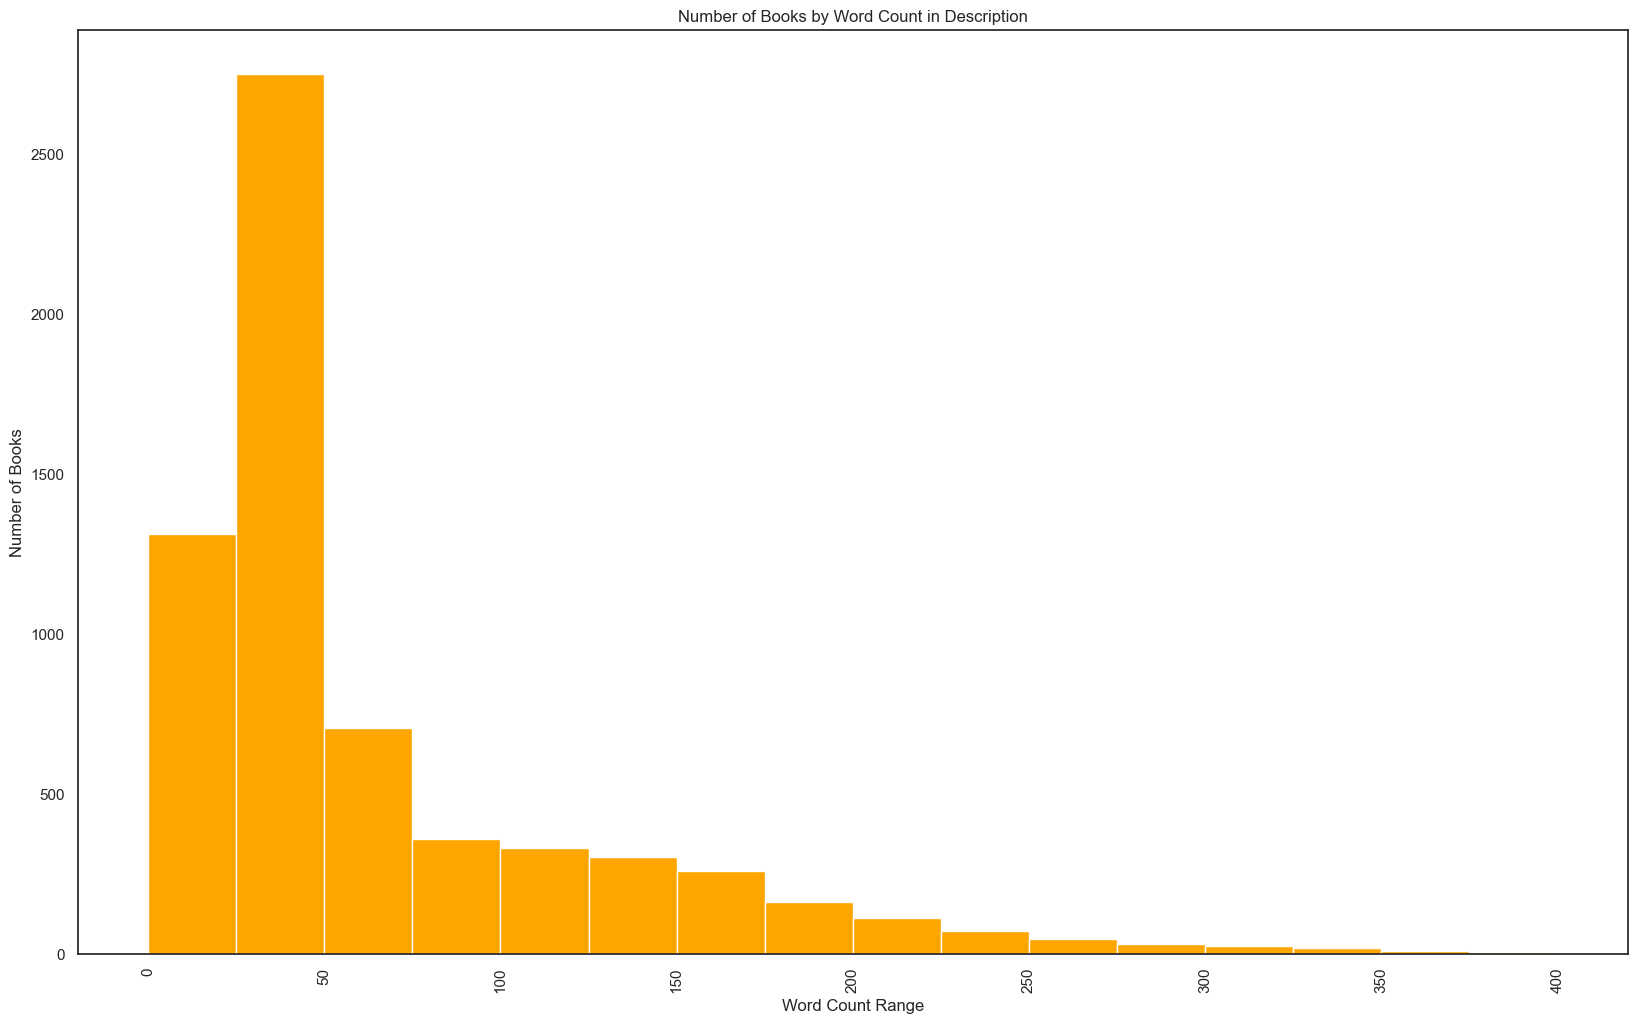

In [391]:
# Membuat bins (kelompok) untuk jumlah kata
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375,400]

# Membuat histogram plot
plt.figure(figsize=(20, 12))
book_mv['total_words_in_desc'].plot(kind='hist', color='orange', bins=bins)
plt.xlabel('Word Count Range')
plt.ylabel('Number of Books')
plt.title('Number of Books by Word Count in Description')
plt.xticks(rotation=90)
plt.show()

**Ternyata kategori sangatlah _imbalanced_. Sementara itu ada juga deskripsi yang cukup pendek**

In [392]:
book_mv.loc[book_mv['total_words_in_desc'].between(1, 4) , "description"]
book_mv.loc[book_mv['total_words_in_desc'].between(5, 14) , "description"]
book_mv.loc[book_mv['total_words_in_desc'].between(15, 24) , "description"]

10      One of Sidney Sheldon's most popular and bests...
32      Tells the story of three generations of Chines...
36      A magical and fantastic collection of early st...
57      A young drifter finds more than he bargained f...
68      A new 'The Doors of Perception' for the 21st c...
                              ...                        
6767    Everything from the fingerprints of the gods t...
6782    Displays one of America's leading physicist's ...
6783    Basics Illustration 01: Thinking Visually expl...
6789    Provides an introduction to the American artis...
6809    This is a jubilant and rewarding collection of...
Name: description, Length: 947, dtype: object

In [393]:
book_mv.loc[book_mv['total_words_in_desc'].between(25, 34) , "description"]

9       Kate Blackwell is an enigma and one of the mos...
14      Available in the U.S. for the first time, this...
20      It is 1937, and Charles Ashworth, a Canon to t...
21      Reissue of the author's most famous and well-l...
46      No one believes a little girl when she insists...
                              ...                        
6760    Joel, an English teacher, has never really lik...
6766    Discusses the historical and intellectual back...
6775    Presents nearly one thousand recipes--from app...
6779    Edited by the creator and executive producer o...
6799    This book is the story of a young girl obsesse...
Name: description, Length: 1229, dtype: object

Dapat dilihat bahwa deskripsi yang bisa dijadikan informasi untuk sistem rekomendasi yakni deskripsi yang memiliki banyak kata lebih dari 25, sehingga deskripsi tersebutlah yang akan digunakan.

In [394]:
book_25 = book_mv[book_mv['total_words_in_desc']>= 25]
book_25.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5197 entries, 0 to 6808
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   isbn13               5197 non-null   int64  
 1   isbn10               5197 non-null   object 
 2   title                5197 non-null   object 
 3   subtitle             1817 non-null   object 
 4   authors              5165 non-null   object 
 5   categories           5167 non-null   object 
 6   thumbnail            5031 non-null   object 
 7   description          5197 non-null   object 
 8   published_year       5197 non-null   float64
 9   average_rating       5197 non-null   float64
 10  num_pages            5197 non-null   float64
 11  ratings_count        5197 non-null   float64
 12  missing_description  5197 non-null   int32  
 13  age_of_book          5197 non-null   float64
 14  total_words_in_desc  5197 non-null   int64  
dtypes: float64(5), int32(1), int64(2), object(7

## Final cleaning

Ingat bahwa terdapat banyak missing value pada subtitle <br>

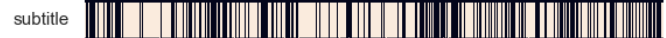

Hal ini bisa diatasi dengan menggabungkan title dan juga subtitle bersamaan.

In [395]:
# Logicnya:
# Jika subtitle missing, maka ganti dengan title
# Jika keduanya ada, maka gabungkan

book_25["title & subtitle"] = (
    np.where(book_25['subtitle'].isna(), book_25['title'],
             book_25[['title','subtitle']].astype(str).agg(": ".join, axis=1))
)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_53572\3240404978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_25["title & subtitle"] = (


Karena di vector database diperlukan identifiers maka akan digunakan isbn

In [396]:
book_25['tagged_description'] = book_25[['isbn13','description']].astype(str).agg(" ".join, axis=1)
book_25['tagged_description']

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_53572\423163472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_25['tagged_description'] = book_25[['isbn13','description']].astype(str).agg(" ".join, axis=1)


0       9780002005883 A NOVEL THAT READERS and critics...
1       9780002261982 A new 'Christie for Christmas' -...
3       9780006178736 A memorable, mesmerizing heroine...
4       9780006280897 Lewis' work on the nature of lov...
5       9780006280934 "In The Problem of Pain, C.S. Le...
                              ...                        
6802    9788172235222 On A Train Journey Home To North...
6803    9788173031014 This book tells the tale of a ma...
6804    9788179921623 Wisdom to Create a Life of Passi...
6805    9788185300535 This collection of the timeless ...
6808    9789027712059 Since the three volume edition o...
Name: tagged_description, Length: 5197, dtype: object

Dan untuk paling terakhir, akan dihilangkan fitur yang tidak akan digunakan

In [397]:
(
    book_25
    .drop(['subtitle', 'missing_description', 
          'age_of_book', 'total_words_in_desc'], axis=1)
    .to_csv('book_cleaned.csv',index = False)
)